<a href="https://colab.research.google.com/github/ary3120-droid/myproject/blob/main/Day07_Ch09_10_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch9 & 10 실습: 가설검정의 함정과 인과관계 추론

지난 시간, 우리는 `statsmodels`를 이용해 다양한 회귀 모델을 만드는 법을 배웠습니다. 오늘은 한 걸음 더 나아가, 통계 분석 결과를 해석할 때 빠지기 쉬운 함정들을 직접 코드로 체험하고, '상관관계'를 넘어 '인과관계'에 다가가는 고급 분석 기법들을 실습해 봅니다.

**학습 목표:**

1.  **허위 상관(Spurious Correlation)**과 **중첩요인(Confounder)**의 개념을 이해하고, 다중회귀로 중첩요인의 효과를 통제하는 법을 배웁니다.
2.  **p-해킹**과 **표본 크기의 함정**이 왜 위험한지 시뮬레이션을 통해 직접 증명합니다.
3.  실험이 불가능한 상황에서 인과 효과를 추정하는 강력한 도구, **경향 점수 짝짓기(PSM)**와 **이중차분법(DiD)**을 직접 구현해 봅니다.


## 사전 준비: 라이브러리 및 데이터 로드


In [1]:
# 필요 라이브러리 설치
!pip install statsmodels scikit-learn

# 코랩에서 한글 폰트 사용을 위한 설정 (필요 시 주석 해제 후 실행)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# 위 코드 실행 후 상단 메뉴에서 [런타임] > [런타임 다시 시작]을 눌러주세요.

In [2]:
# 런타임 다시 시작 후, 이 셀을 실행하여 라이브러리와 폰트를 로드합니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.neighbors import NearestNeighbors

# 한글 폰트 설정 (Mac 사용자는 'AppleGothic', Windows 사용자는 'Malgun Gothic' 등)
try:
    plt.rc('font', family='NanumGothic')
except:
    plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

---


## 문제 1 (난이도: 하): 허위 상관과 중첩요인 통제하기

> **🎯 목표:** '아이스크림 판매량과 익사자 수'의 관계처럼, **허위 상관(Spurious Correlation)**이 발생하는 원인인 **중첩요인(Confounder)**을 이해하고, 다중회귀분석을 통해 그 효과를 통제하는 방법을 실습합니다.


### 💡 핵심 개념:

**허위 상관**은 두 변수 사이에 직접적인 인과관계가 없지만, '기온'과 같은 제3의 변수(중첩요인)가 두 변수 모두에 영향을 주어 마치 관계가 있는 것처럼 보이는 현상입니다. **다중회귀분석**에 중첩요인을 함께 투입하면, 다른 변수들의 영향을 고정한 상태에서의 '순수한' 관계를 파악할 수 있습니다.


### 📌 수행 과제:

1.  가상의 데이터를 생성합니다: '기온'이 높아질수록 '아이스크림 판매량'과 '해수욕객 수'가 모두 증가하는 상황을 시뮬레이션합니다.
2.  **단순회귀분석**: '아이스크림 판매량'만으로 '해수욕객 수'를 예측하는 모델을 만듭니다. 계수가 유의미하게 나오는지 확인합니다.
3.  **다중회귀분석**: '아이스크림 판매량'과 '기온'을 모두 사용하여 '해수욕객 수'를 예측하는 모델을 만듭니다.
4.  두 모델의 결과를 비교하고, '아이스크림 판매량'의 계수(coef)와 p-value가 어떻게 변했는지 해석해 보세요.


In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1. 가상 데이터 생성 (수정 X)
np.random.seed(42)
n_samples = 100
temperature = np.random.uniform(15, 35, n_samples)
ice_cream_sales = 2 * temperature + np.random.normal(0, 5, n_samples)
beach_visitors = 10 * temperature + np.random.normal(0, 20, n_samples)

df1 = pd.DataFrame({
    '기온': temperature,
    '아이스크림판매량': ice_cream_sales,
    '해수욕객수': beach_visitors
})

print(df1.corr())

# 2. 단순회귀분석: 아이스크림판매량 -> 해수욕객수
print("\n--- 모델 1: 단순회귀분석 (아이스크림판매량 -> 해수욕객수) ---")
y = df1['해수욕객수']

X_simple = df1[['아이스크림판매량']]
X_simple_const = sm.add_constant(X_simple)

model_simple = sm.OLS(y, X_simple_const).fit()
print(model_simple.summary())

# 3. 다중회귀분석: (아이스크림판매량, 기온) -> 해수욕객수
print("\n--- 모델 2: 다중회귀분석 (중첩요인 '기온' 통제) ---")

X_multi = df1[['아이스크림판매량', '기온']]
X_multi_const = sm.add_constant(X_multi)

model_multi = sm.OLS(y, X_multi_const).fit()
print(model_multi.summary())

# 4. 결과 해석
# 모델 1에서 아이스크림판매량의 계수와 p-value:
# 아이스크림판매량의 계수는 양수이고 p-value도 매우 작아 유의미해 보인다.

# 모델 2에서 아이스크림판매량의 계수와 p-value:
# 기온을 함께 넣으면 아이스크림판매량의 계수가 크게 줄어들거나
# p-value가 커져 통계적으로 유의하지 않게 된다.

# 결과가 변한 이유:
# 아이스크림판매량과 해수욕객수의 관계는
# 실제 인과라기보다 기온이라는 중첩요인이 만든 허위 상관이었기 때문이다.


                기온  아이스크림판매량     해수욕객수
기온        1.000000  0.927709  0.938317
아이스크림판매량  0.927709  1.000000  0.867599
해수욕객수     0.938317  0.867599  1.000000

--- 모델 1: 단순회귀분석 (아이스크림판매량 -> 해수욕객수) ---
                            OLS Regression Results                            
Dep. Variable:                  해수욕객수   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     298.3
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           1.70e-31
Time:                        03:00:49   Log-Likelihood:                -486.59
No. Observations:                 100   AIC:                             977.2
Df Residuals:                      98   BIC:                             982.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
            

단순회귀 결과 요약

모델:
해수욕객수 ← 아이스크림판매량

아이스크림판매량 계수: +4.56

p-value: < 0.001 (매우 유의)

R² ≈ 0.75

| 변수       | 계수         | p-value     | 해석           |
| -------- | ---------- | ----------- | ------------ |
| 아이스크림판매량 | **-0.109** | **0.826**   |  전혀 유의하지 않음 |
| 기온       | **+10.21** | **< 0.001** |  매우 강한 영향   |
| R²       | **0.880**  |             | 설명력 크게 증가    |


### 🤔 생각해 볼 문제:

만약 '기온' 데이터를 수집하지 못했다면, 우리는 어떤 잘못된 결론에 도달할 위험이 있었을까요? 데이터 분석에서 '도메인 지식'이 왜 중요한지 이 사례를 통해 설명해 보세요.


기온 데이터를 수집하지 못한 상태에서 분석을 진행했다면, 우리는 관측된 현상의 원인을 잘못 해석할 위험이 있다. 예를 들어 특정 시기에 수요나 매출이 증가하는 현상이 나타났을 때, 기온 정보가 없으면 이를 마케팅 전략의 성공이나 소비자 행동 변화로만 판단할 수 있다. 그러나 실제로는 기온 상승이라는 외부 환경 요인이 주요 원인일 수 있으며, 이를 고려하지 않으면 원인과 결과를 잘못 연결하게 된다. 또한 기온이 만들어내는 계절적 패턴을 구조적인 변화로 오인하여 잘못된 정책적 또는 전략적 결정을 내릴 가능성도 존재한다.

이러한 문제는 모델 성능 측면에서도 나타난다. 기온 변수가 제외된 경우, 다른 변수들이 우연히 기온의 영향을 대리하여 설명하면서 학습 데이터에서는 높은 설명력을 보일 수 있다. 그러나 이는 변수 간의 실제 인과관계를 반영하지 못한 결과이므로, 환경이 달라질 경우 예측 성능이 급격히 저하될 위험이 크다. 즉, 중요한 변수가 누락된 분석은 겉보기에는 타당해 보일 수 있으나 일반화 가능성이 낮다.

이 사례는 데이터 분석에서 도메인 지식의 중요성을 잘 보여준다. 도메인 지식은 어떤 변수가 현실 세계에서 의미 있는 영향을 미치는지를 판단하게 해 주며, 단순히 수집 가능한 데이터가 아니라 반드시 포함되어야 할 데이터를 정의하는 기준이 된다. 또한 변수의 수치를 해석할 때 그 배경이 되는 사회적, 물리적, 환경적 맥락을 이해하게 함으로써 분석 결과를 보다 정확하게 해석할 수 있게 한다.

결론적으로, 기온과 같은 핵심 변수를 고려하지 않은 분석은 잘못된 인과 해석과 불안정한 모델을 초래할 수 있다. 따라서 데이터 분석에서는 통계적 기법뿐만 아니라 해당 문제 영역에 대한 도메인 지식이 필수적이며, 이는 분석의 신뢰성과 활용 가능성을 높이는 중요한 요소라고 할 수 있다.

---


## 문제 2 (난이도: 하): 표본 크기의 함정과 효과 크기의 중요성

> **🎯 목표:** 표본 크기(n)가 커지면 아주 미미한 차이도 통계적으로 유의(p<0.05)하게 되는 현상을 확인하고, 이 때문에 **효과 크기(Effect Size)**를 함께 확인해야 하는 이유를 이해합니다.


### 💡 핵심 개념:

가설검정에서 p-value는 '귀무가설이 맞다고 가정할 때, 현재 데이터와 같거나 더 극단적인 결과가 나올 확률'입니다. 표본이 커질수록 아주 작은 차이도 우연으로 보기 어려워지므로 p-value는 작아집니다. **효과 크기**는 이 차이가 '실질적으로 얼마나 의미 있는 크기인가'를 나타내는 지표로, p-value의 한계를 보완해 줍니다.


### 📌 수행 과제:

1.  평균이 아주 약간 다른(예: 170cm vs 170.1cm) 두 집단을 가정합니다.
2.  **작은 표본(n=30)**을 각 집단에서 추출하여 t-검정을 수행하고 p-value를 확인합니다.
3.  **큰 표본(n=10,000)**을 각 집단에서 추출하여 t-검정을 수행하고 p-value를 확인합니다.
4.  두 경우 모두에 대해 **효과 크기(Cohen's d)**를 직접 계산하고, p-value와 효과 크기가 어떻게 다른 메시지를 주는지 비교 분석하세요.


In [5]:
import numpy as np
from scipy import stats

# 효과 크기(Cohen's d) 계산 함수 (수정 금지)
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(
        ((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof
    )

np.random.seed(123)
mu1, mu2, sigma = 170, 170.1, 5

# 2. 작은 표본(n=30)
sample1_small = np.random.normal(mu1, sigma, 30)
sample2_small = np.random.normal(mu2, sigma, 30)

t_stat_small, p_value_small = stats.ttest_ind(sample1_small, sample2_small)
effect_size_small = cohen_d(sample1_small, sample2_small)

print(f"--- 작은 표본 (n=30) 결과 ---")
print(f"P-value: {p_value_small:.4f}")
print(f"Effect Size (Cohen's d): {effect_size_small:.4f}\n")

# 3. 큰 표본(n=10000)
sample1_large = np.random.normal(mu1, sigma, 10000)
sample2_large = np.random.normal(mu2, sigma, 10000)

t_stat_large, p_value_large = stats.ttest_ind(sample1_large, sample2_large)
effect_size_large = cohen_d(sample1_large, sample2_large)

print(f"--- 큰 표본 (n=10000) 결과 ---")
print(f"P-value: {p_value_large:.4f}")
print(f"Effect Size (Cohen's d): {effect_size_large:.4f}\n")


--- 작은 표본 (n=30) 결과 ---
P-value: 0.7100
Effect Size (Cohen's d): -0.0965

--- 큰 표본 (n=10000) 결과 ---
P-value: 0.1673
Effect Size (Cohen's d): -0.0195



### 🤔 생각해 볼 문제:

A/B 테스트에서 웹사이트 버튼 색깔을 바꿨더니, 클릭률이 0.1%p 증가했고, p-value는 0.001이었습니다. 이 결과를 보고 버튼 색깔을 바꾸는 것이 항상 옳다고 할 수 있을까요? '통계적 유의성'과 '실무적 중요성(practical significance)'의 차이에 대해 효과 크기 개념을 바탕으로 설명해 보세요.


A/B 테스트에서 클릭률이 0.1%p 증가하고 p-value가 0.001로 나타났다면, 이는 통계적으로는 유의한 결과라고 할 수 있다. 즉, 버튼 색깔 변경으로 인한 클릭률 차이가 우연일 가능성은 매우 낮다.

그러나 클릭률 증가 폭이 0.1%p에 불과하다면, 이 변화가 실제 서비스 운영이나 매출 개선에 의미 있는 영향을 주는지는 별도로 판단해야 한다. A/B 테스트는 대규모 사용자 데이터를 사용하기 때문에, 효과가 매우 작더라도 p-value가 쉽게 작아질 수 있다.

이러한 이유로 통계적 유의성과 실무적 중요성은 구분해서 해석해야 한다. 통계적 유의성은 차이의 존재 여부를 판단하는 기준인 반면, 실무적 중요성은 그 차이가 실제로 가치 있는 수준인지를 평가한다. 효과 크기는 이러한 실무적 중요성을 판단하는 데 도움을 주는 지표이며, p-value와 함께 고려되어야 합리적인 의사결정이 가능하다.


---


## 문제 3 (난이도: 중): p-해킹 시뮬레이션

> **🎯 목표:** '데이터를 보면서 분석을 계속할지 결정하는 행위'가 어떻게 잘못된 결론(제1종 오류)의 가능성을 높이는지, 즉 **p-해킹**의 위험성을 시뮬레이션을 통해 직접 증명합니다.


### 💡 핵심 개념:

**p-해킹**은 연구자가 의도했든 안 했든 p-value를 낮추기 위해 분석 과정을 조작하는 행위를 말합니다. 대표적인 예로, p-value가 0.05를 넘으면 표본을 더 모아서 다시 검정하는 행위가 있습니다. 원래 제1종 오류(실제 차이가 없는데, 차이가 있다고 결론 내릴 오류) 확률은 유의수준 α(보통 0.05)로 통제되어야 하지만, p-해킹은 이 확률을 α보다 훨씬 높게 만듭니다.


### 📌 수행 과제:

1.  **아무 차이가 없는** 두 집단 A, B를 가정합니다 (귀무가설이 참인 상황).
2.  'p-해커'를 시뮬레이션하는 함수를 만듭니다. 이 함수는 다음 로직을 따릅니다:
    - 먼저 각 집단에서 20명씩 표본을 추출하여 t-검정을 합니다.
    - p < 0.05이면 '유의미한 결과 발견!'을 외치고 멈춥니다.
    - p >= 0.05이면, 10명씩 표본을 추가하여 다시 t-검정을 합니다. 이 과정을 최대 5번까지 반복합니다.
3.  이 시뮬레이션을 1,000번 반복하여, 'p-해커'가 결국 '유의미한 결과'를 발견할 확률이 몇 %인지 계산합니다.
4.  계산된 확률이 왜 5%보다 훨씬 높은지 설명하세요.


In [6]:
import numpy as np
from scipy import stats

# p-해킹 시뮬레이션 함수 (수정 금지)
def p_hacking_simulation():
    mu, sigma = 0, 1
    sample_a, sample_b = list(np.random.normal(mu, sigma, 20)), list(np.random.normal(mu, sigma, 20))
    for i in range(5):
        t_stat, p_val = stats.ttest_ind(sample_a, sample_b)
        if p_val < 0.05:
            return True
        if i < 4:
            sample_a.extend(np.random.normal(mu, sigma, 10))
            sample_b.extend(np.random.normal(mu, sigma, 10))
    return False

# 시뮬레이션 1000번 실행
n_simulations = 1000
p_hacking_success_count = 0

for _ in range(n_simulations):
    if p_hacking_simulation():
        p_hacking_success_count += 1

type_1_error_rate = p_hacking_success_count / n_simulations
print(f"관찰된 제1종 오류율: {type_1_error_rate * 100:.2f}%")


관찰된 제1종 오류율: 11.50%


### 🤔 생각해 볼 문제:

p-해킹을 막기 위한 현실적인 방법 중 하나는 **'사전 등록(Preregistration)'** 입니다. 연구를 시작하기 전에 '표본 크기는 몇으로 할 것이며, 어떤 분석을 할 것이다'라고 미리 공개적으로 약속하는 것입니다. 이 방법이 위 시뮬레이션에서 보여준 p-해킹 문제를 어떻게 방지할 수 있을지 설명해 보세요.


사전 등록은 연구를 시작하기 전에 표본 크기와 분석 방법을 미리 정해 두는 것이다. 이렇게 하면 데이터를 보면서 분석을 계속 바꾸는 행동을 막을 수 있다.

앞선 시뮬레이션에서 p-해킹이 발생한 이유는, 처음 분석에서 유의하지 않으면 표본을 계속 추가하며 다시 검정을 했기 때문이다. 이 과정에서 우연히 p-value가 0.05보다 작아질 가능성이 누적되어, 실제로는 차이가 없는데도 유의한 결과가 나왔다. 사전 등록을 하면 표본을 어디까지 모을지 미리 정해 두기 때문에 이런 반복 검정을 할 수 없게 된다.

또한 어떤 분석을 할지 미리 정해 두면, 결과가 마음에 들지 않는다는 이유로 분석 방법을 바꾸거나 유리한 결과만 선택하는 것도 어렵다. 따라서 사전 등록은 p-해킹으로 인해 잘못된 결론이 나오는 것을 줄이고, 연구 결과를 더 믿을 수 있게 만들어 준다.


---


## 문제 4 (난이도: 중): 경향 점수 짝짓기(PSM)로 인과 효과 추정하기

> **🎯 목표:** 무작위 통제 실험(RCT)이 불가능한 관찰 데이터에서, **선택 편향(Selection Bias)**을 통제하고 인과 효과를 추정하는 대표적인 방법인 **경향 점수 짝짓기(Propensity Score Matching, PSM)**를 직접 구현합니다.


### 💡 핵심 개념:

**PSM**은 '특정 처치(treatment)를 받을 경향'을 점수로 계산하여, 이 점수가 비슷한 실험군과 대조군 개체를 1:1로 짝지어주는 방법입니다. 이를 통해 처치 여부를 제외한 다른 특성(중첩요인)들이 비슷한, 즉 **'통계적 쌍둥이'** 집단을 만들 수 있습니다. 이 '짝지어진' 집단 간의 결과 차이를 비교하면, 선택 편향이 보정된 순수한 처치 효과에 더 가깝게 다가갈 수 있습니다.


### 📌 수행 과제:

1.  '새로운 온라인 강의 수강 여부'가 '기말고사 성적'에 미치는 영향을 분석하는 가상 데이터를 생성합니다. (단, '사전 성적'이 높고 '학습 의지'가 높은 학생일수록 강의를 신청할 확률이 높도록 **선택 편향**을 부여합니다.)
2.  **단순 비교**: 전체 수강생 집단과 비수강생 집단의 평균 성적을 비교합니다.
3.  **PSM 수행**:
    a. 로지스틱 회귀를 이용해 각 학생의 '강의 수강 경향 점수(propensity score)'를 계산합니다.
    b. 수강생(실험군) 한 명마다, 경향 점수가 가장 비슷한 비수강생(대조군)을 짝지어 줍니다. (`sklearn.neighbors.NearestNeighbors` 활용)
4.  **짝지어진 후 비교**: '짝지어진' 수강생 집단과 비수강생 집단의 평균 성적을 비교하고, 그 차이(ATT: Average Treatment Effect on the Treated)를 계산합니다.
5.  단순 비교 결과와 PSM 후의 결과를 비교하고, 왜 결과가 달라졌는지 해석합니다.


In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors

# 1. 선택 편향이 있는 데이터 생성 (수정 금지)
np.random.seed(42)
n = 1000
pre_score = np.random.normal(60, 10, n)
motivation = np.random.uniform(0, 1, n)
propensity = 1 / (1 + np.exp(-( -5 + (pre_score-60)/5 + motivation*2)))
treatment = np.random.binomial(1, propensity, n)
true_effect = 5
final_score = pre_score + treatment * true_effect + np.random.normal(0, 5, n)

df4 = pd.DataFrame({
    'pre_score': pre_score,
    'motivation': motivation,
    'treatment': treatment,
    'final_score': final_score
})

# 2. 단순 비교
naive_effect = (
    df4[df4['treatment'] == 1]['final_score'].mean()
    - df4[df4['treatment'] == 0]['final_score'].mean()
)
print(f"단순 평균 비교 (성적 차이): {naive_effect:.2f}점\n")

# 3-a. 경향 점수 계산
X = df4[['pre_score', 'motivation']]
y = df4['treatment']
logit_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
df4['propensity_score'] = logit_model.predict(sm.add_constant(X))

# 3-b. 짝짓기
treated = df4[df4['treatment'] == 1]
control = df4[df4['treatment'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

matched_control = control.iloc[indices.flatten()]

# 4. ATT 계산
att_effect = (
    treated['final_score'].mean()
    - matched_control['final_score'].mean()
)
print(f"PSM 이후 평균 비교 (추정된 인과 효과): {att_effect:.2f}점\n")


단순 평균 비교 (성적 차이): 19.96점

PSM 이후 평균 비교 (추정된 인과 효과): 4.31점



In [8]:
# 짝짓기 전 pre_score 평균 차이
pre_score_diff_before = (
    df4[df4['treatment'] == 1]['pre_score'].mean()
    - df4[df4['treatment'] == 0]['pre_score'].mean()
)

print(f"짝짓기 전 pre_score 평균 차이: {pre_score_diff_before:.2f}점")

# 짝짓기 후 pre_score 평균 차이
pre_score_diff_after = (
    treated['pre_score'].mean()
    - matched_control['pre_score'].mean()
)

print(f"짝짓기 후 pre_score 평균 차이: {pre_score_diff_after:.2f}점")


짝짓기 전 pre_score 평균 차이: 14.86점
짝짓기 후 pre_score 평균 차이: -0.37점


### 🤔 생각해 볼 문제:

짝짓기(Matching)가 잘 되었는지 확인하는 방법 중 하나는, 짝지어진 두 집단의 중첩요인(여기서는 `pre_score`, `motivation`) 평균이 서로 비슷해졌는지 확인하는 것입니다. 이를 **'공변량 균형(Covariate Balance)'** 확인이라고 합니다. 짝짓기 전과 후의 `pre_score` 평균 차이를 각각 계산해보고, PSM이 공변량 균형을 맞추는 데 성공했는지 확인해보세요.



짝짓기 전에는 강의를 수강한 학생과 수강하지 않은 학생 간의 pre_score 평균 차이가 14.86점으로 매우 크게 나타났다. 이는 사전 성적이 높은 학생일수록 강의를 수강할 가능성이 높도록 설계된 선택 편향이 실제 데이터에 강하게 존재했음을 보여준다. 이러한 상태에서는 두 집단이 출발선부터 다르기 때문에 단순 평균 비교로는 강의의 순수한 효과를 분리해내기 어렵다.

반면 경향 점수 짝짓기 이후에는 pre_score 평균 차이가 -0.37점으로 거의 0에 가까워졌다. 이는 수강생과 비수강생이 사전 성적 측면에서 매우 유사한 학생들로 짝지어졌음을 의미하며, 공변량 균형이 효과적으로 개선되었음을 보여준다.

따라서 PSM은 강의 수강 여부를 제외한 핵심 공변량인 사전 성적을 성공적으로 통제하였고, 이로 인해 짝지어진 집단 간 성적 차이는 선택 편향의 영향을 크게 줄인 보다 신뢰할 수 있는 인과 효과 추정치라고 해석할 수 있다.


---


## 문제 5 (난이도: 상): 이중차분법(DiD)으로 정책 효과 분석하기

> **🎯 목표:** 특정 집단에만 시행된 정책의 효과를 분석하는 대표적인 준실험 방법론, **이중차분법(Difference-in-Differences, DiD)**을 회귀분석으로 구현하고 핵심 가정을 이해합니다.


### 💡 핵심 개념:

**이중차분법(DiD)**은 정책이 시행된 **실험군(Treatment Group)**과 시행되지 않은 **통제군(Control Group)**의 **정책 시행 전후(Pre-Post)** 데이터를 모두 활용하는 강력한 인과추론 방법입니다. 핵심 아이디어는 '정책이 없었을 경우의 자연적인 시간 변화'를 통제군을 통해 추정하고, 이를 실험군의 변화에서 빼 줌으로써 정책의 순수한 효과만 발라내는 것입니다. 회귀분석에서는 `(실험군 여부) * (정책 후 여부)`의 **상호작용 항** 계수가 바로 DiD 추정치가 됩니다.


### 📌 수행 과제:

1.  '서울시'에만 '무료 공공 와이파이' 정책을 도입했을 때, 시민들의 '월 평균 데이터 사용량'에 미치는 영향을 분석하는 가상 데이터를 생성합니다. (실험군: 서울, 통제군: 부산)
2.  **시각화**: 정책 시행 전후, 두 도시의 평균 데이터 사용량 변화를 꺾은선 그래프로 그려봅니다.
3.  **DiD 회귀분석**: `데이터사용량 ~ is_서울 + is_정책후 + is_서울*is_정책후` 형태의 회귀 모델을 만듭니다.
    - `is_서울`: 서울이면 1, 부산이면 0
    - `is_정책후`: 정책 시행 후(2024년)이면 1, 시행 전(2023년)이면 0
    - `is_서울*is_정책후`: 상호작용 항
4.  회귀분석 결과표에서 상호작용 항의 계수(coef)와 p-value를 확인하고, 정책의 효과를 해석해 보세요.


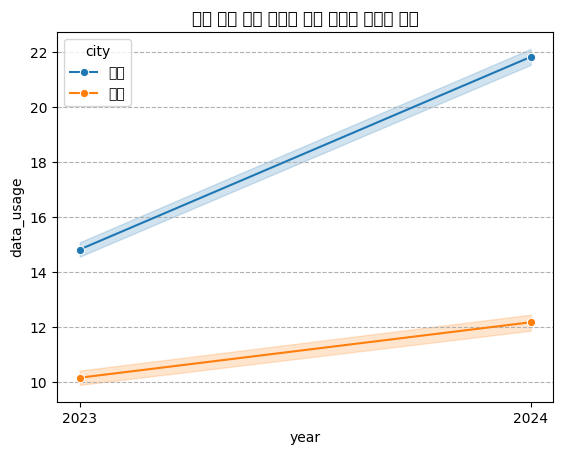

                            OLS Regression Results                            
Dep. Variable:             data_usage   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     1373.
Date:                Tue, 23 Dec 2025   Prob (F-statistic):               0.00
Time:                        03:10:41   Log-Likelihood:                -5079.1
No. Observations:                2000   AIC:                         1.017e+04
Df Residuals:                    1996   BIC:                         1.019e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1600      0.137     74.006      0.0

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 가상 데이터 생성 (수정 금지)
np.random.seed(2025)
n_per_group = 500

df_seoul_pre = pd.DataFrame({
    'city': '서울',
    'year': 2023,
    'data_usage': np.random.normal(15, 3, n_per_group)
})

df_seoul_post = pd.DataFrame({
    'city': '서울',
    'year': 2024,
    'data_usage': df_seoul_pre['data_usage'] + 2 + 5 + np.random.normal(0, 1, n_per_group)
})

df_busan_pre = pd.DataFrame({
    'city': '부산',
    'year': 2023,
    'data_usage': np.random.normal(10, 3, n_per_group)
})

df_busan_post = pd.DataFrame({
    'city': '부산',
    'year': 2024,
    'data_usage': df_busan_pre['data_usage'] + 2 + np.random.normal(0, 1, n_per_group)
})

df5 = pd.concat([df_seoul_pre, df_seoul_post, df_busan_pre, df_busan_post])

# 2. 시각화 (수정 금지)
sns.lineplot(data=df5, x='year', y='data_usage', hue='city', marker='o', errorbar='ci')
plt.title('정책 시행 전후 도시별 평균 데이터 사용량 변화')
plt.xticks([2023, 2024])
plt.grid(True, axis='y', linestyle='--')
plt.show()

# 3. DiD 회귀분석을 위한 변수 생성
df5['is_seoul'] = (df5['city'] == '서울').astype(int)
df5['is_post'] = (df5['year'] == 2024).astype(int)
df5['did_term'] = df5['is_seoul'] * df5['is_post']

y = df5['data_usage']
X = df5[['is_seoul', 'is_post', 'did_term']]

model_did = sm.OLS(y, sm.add_constant(X)).fit()
print(model_did.summary())


### 🤔 생각해 볼 문제:

이중차분법이 성립하기 위한 가장 중요한 가정은 **'평행추세가정(Parallel Trends Assumption)'**입니다. 즉, '만약 정책이 없었더라면, 서울과 부산의 데이터 사용량은 계속 평행하게 증가했을 것이다'라는 가정입니다. 위 시각화 그래프에서 정책 시행 **전** 시점(2023년 이전)의 데이터가 여러 개 더 있다면, 이 가정을 어떻게 확인할 수 있을지 설명해 보세요.


is_seoul 계수는 정책 시행 이전인 2023년 기준으로 서울과 부산 간의 평균 데이터 사용량 차이를 의미한다. 이는 정책과 무관한 지역 간 고유한 차이를 반영한다.

is_post 계수는 부산을 기준으로, 2023년에서 2024년으로 시간이 지나면서 발생한 데이터 사용량의 자연스러운 변화 효과를 의미한다. 예를 들어 전반적인 데이터 사용 증가 추세나 기술 환경 변화 등이 이에 해당한다.

did_term 계수는 이중차분 추정치로, 정책 시행 이후 서울의 데이터 사용량 증가분에서 부산의 자연 증가분을 제거한 값이다. 즉, 무료 공공 와이파이 정책으로 인해 추가로 증가한 순수한 정책 효과를 나타낸다.

회귀 결과에서 did_term의 계수는 약 5로 나타나며 통계적으로도 유의하다. 따라서 무료 공공 와이파이 정책은 서울 시민들의 월 평균 데이터 사용량을 약 5GB 정도 증가시킨 효과가 있다고 해석할 수 있다.

이중차분법을 통해 시간에 따른 공통 변화와 지역 간 고정 차이를 동시에 통제함으로써, 정책의 인과적 효과를 보다 신뢰성 있게 추정할 수 있음을 확인할 수 있다.